#  Unsupervised learning addition model with generator

Author: S. Menary [sbmenary@gmail.com]

Date: 5/4/2023  (last update: 9/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, math, os, pickle, random, sys, time

##  Import entire pypi packages
import numpy      as np
import tensorflow as tf

##  Import individual modules/objects from python stdlib packages
from pathlib import Path

##  Import individual modules/objects from pypi packages
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer.data        import TokenTransform
from mathsformer.tf_objects  import (create_custom_objects_dict, masked_accuracy, masked_sparse_categorical_crossentropy, 
                                     MetricRecord, LayerWeightsRecord, LoggerCallback)
from mathsformer.transformer import create_text_to_text_model, Transformer_Text_to_Text
from mathsformer.utils       import create_working_directory, fancy_message, initialise_program


### Configuation

Set global configuration variables

In [27]:
##===================##
##   Global config   ##
##===================##

##  Create dictionary of config values
##  -  config values to be set here and never changed!
##  -  use nested dictionary as a proxy for namespacing
global_config = {
    "base_seed"         : -1,
    "working_directory" : "unsupervised_learning_addition_model_generator_[tag]_[date]",
    "tag"               : "baseline",
    "log_lvl_iostream"  : logging.INFO,
    "log_lvl_fstream"   : logging.DEBUG,
    "data" : {
        "train_int_lengths" : [1, 2, 4, 6],
        "train_num_ints"    : [1, 2, 4, 6],
        "test_int_lengths"  : [3, 5],
        "test_num_ints"     : [3, 5],
        "characters"        : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"         : 'M',
        "seq_start_char"    : 'B',
        "seq_end_char"      : 'E',
        "negative_char"     : 'N',
        "dtype"             : "int32",
    },
    "model" : {
        "load_pretrained_model" : "",
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "learning_rate"         : 1e-3,
        "positional_encoding" : {
            "num_freqs"         : 16,
            "min_period"        : 4,
            "max_period"        : 300,
        },
        "ndim_embedding"        : 32,
        "comb_type"             : 'average',
        "pre_encoder" : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "pre_decoder" : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "encoder" : {
            "num_blocks"        : 2,
            "num_heads"         : 6,
            "ndim"              : 32,
            "ndim_att_hidden"   : 32,
            "ndim_ff_hidden"    : 64,
        },
        "decoder" : {
            "num_blocks"        : 2,
            "num_heads"         : 6,
            "ndim"              : 32,
            "ndim_att_hidden"   : 32,
            "ndim_ff_hidden"    : 64,
        },
        "post_decoder" : {
            "num_layers"        : 2,
            "ndim"              : 128,
        },
    },
    "training" : {
        "train"                   : True,
        "max_epochs"              : 10000,
        "batch_size"              : 32,
        "num_batchs"              : 4000,
        "val_num_batchs"          : 500,
        "early_stopping"          : False,
        "early_stopping_patience" : 5,
        "layer_weights_record_batch_frequency" : 250, 
        "layer_weights_record_recursive"       : True, 
    },
    "evaluate" : {
        "num_print" : 20,
    },
}


##  Report success
print(fancy_message(f"Created global_config"))


===   Created global_config   ===


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [26]:
##===============================##
##   Global config - continued   ##
##===============================##

def validate_config(config) :
    """Raise exceptions in the case of program misconfigurations"""
    mask_char      = global_config["data"]["mask_char"]
    seq_start_char = global_config["data"]["seq_start_char"]
    seq_end_char   = global_config["data"]["seq_end_char"]
    negative_char  = global_config["data"]["negative_char"]
    char_tokens    = global_config["data"]["characters"]
    
    ##  Check that only single character tokens are provided
    for char_token in char_tokens :
        if len(char_token) == 1 : continue
        raise ValueError(f"All character tokens must be single characters but '{char_tokens}' found")
        
    ##  Check mask character is provided
    if len(mask_char) != 1 :
        raise ValueError(f"Mask character must be a single character but '{mask_char}' provided")
        
    ##  Check mask character in character list
    if mask_char not in char_tokens :
        raise ValueError(f"Mask character '{mask_char}' not found in character list: {char_tokens}")
    
    ##  Check that mask character is first in char_tokens list (ensures it's assigned a token of 0)
    if char_tokens[0] != mask_char :
        raise ValueError(f"Mask character '{mask_char}' must be the first in the char_tokens list provided, "
                        +f"instead found list: {char_tokens}")
        
    ##  Check seq_start_char character is provided
    if len(seq_start_char) != 1 :
        raise ValueError(f"Sequence start character must be a single character but '{seq_start_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_start_char not in char_tokens :
        raise ValueError(f"Sequence start character '{seq_start_char}' not found in character list: {char_tokens}")
        
    ##  Check seq_end_char character is provided
    if len(seq_end_char) != 1 :
        raise ValueError(f"Sequence end character must be a single character but '{seq_end_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_end_char not in char_tokens :
        raise ValueError(f"Sequence end character '{seq_end_char}' not found in character list: {char_tokens}")
        
    ##  Check negative_char character is provided
    if len(negative_char) != 1 :
        raise ValueError(f"Negative symbol character must be a single character but '{negative_char}' provided")
        
    ##  Check negative_char character in character list
    if negative_char not in char_tokens :
        raise ValueError(f"Negative symbol character '{negative_char}' not found in character list: {char_tokens}")
        
    ##  If here then config validated correctly
    print(fancy_message("Config successfully validated"))
    
validate_config(global_config)

===   Config successfully validated   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = initialise_program(
    "unsupervised_learning_model notebook", 
    working_dir       = global_config["working_directory"], 
    global_config     = global_config,
    log_lvl_iostream  = global_config["log_lvl_iostream"],
    log_lvl_fstream   = global_config["log_lvl_fstream" ],
)


===   Working directory created at unsupervised_learning_addition_model_generator_baseline_2023_04_13   ===
   INFO initialise_logging: Begin logging on 2023-04-13 at 16:25:37
   INFO initialise_program: Program description: unsupervised_learning_model notebook
   INFO initialise_program: Working directory: unsupervised_learning_addition_model_generator_baseline_2023_04_13
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                               Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO log_versions:                                    

   INFO log_versions:                                 platformdirs.version  |  2.6.0
   INFO log_versions:                                       prompt_toolkit  |  3.0.36
   INFO log_versions:                                               psutil  |  5.9.4
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.1
   INFO log_versions:                                             pygments  |  2.13.0
   INFO log_versions:                                            pyparsing  |  3.0.9
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.28.1
   INFO log_versions:                                 requests

   INFO initialise_program: Registered global config value model > positional_encoding > min_period: 4
   INFO initialise_program: Registered global config value model > positional_encoding > max_period: 300
   INFO initialise_program: Registered global config value model > ndim_embedding: 32
   INFO initialise_program: Registered global config value model > comb_type: average
   INFO initialise_program: Registered global config value model > pre_encoder > num_layers: -1
   INFO initialise_program: Registered global config value model > pre_encoder > ndim: 128
   INFO initialise_program: Registered global config value model > pre_encoder > skip_connect: True
   INFO initialise_program: Registered global config value model > pre_decoder > num_layers: -1
   INFO initialise_program: Registered global config value model > pre_decoder > ndim: 128
   INFO initialise_program: Registered global config value model > pre_decoder > skip_connect: True
   INFO initialise_program: Registered global 

##  3. Create training data

###  Generate string-string pairs

In [5]:

token_transform = TokenTransform.from_dictionary(global_config["data"])
token_transform.summary(print_fn=logger.info)



   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


In [18]:
class RandomDataGenerator(tf.keras.utils.Sequence) :
    
    def __init__(self, token_transform:TokenTransform, int_lengths:list, num_ints:list, batch_size:int, num_batches:int) :
        """
        """
        self.token_transform       = token_transform
        self.int_lengths           = int_lengths
        self.num_ints              = num_ints
        self.batch_size            = batch_size
        self.num_batches           = num_batches
        self._generate_int_strings = np.vectorize(self._generate_int_string)
    
    
    def __getitem__(self, index:int) :
        """
        Returns ([X, Y_in], Y_out)
        """
        x = np.random.choice(self.num_ints, size=(self.batch_size,))
        y = [generate_string(xp, self.int_lengths) for xp in x]
        X, Y = [yp[0] for yp in y], [yp[1] for yp in y]
        X = self.token_transform.strings_to_tensor(X)
        Y = self.token_transform.strings_to_tensor(Y)
        return [X, Y[:,:-1]], Y[:,1:]
    
    
    def __len__(self) :
        """
        """
        return self.num_batches
    
    
    @staticmethod
    def _generate_int_string(length) :
        """
        """
        sign        = np.random.choice(["", "N"])
        lead_char   = str(np.random.randint(1, 10))
        other_chars = "".join([str(np.random.randint(0, 10)) for i in range(length-1)])
        return sign + lead_char + other_chars
    
    
    @staticmethod
    def _generate_string(num, lengths) :
        """
        """
        lengths = np.random.choice(lengths, size=(num,))
        ints    = self._generate_int_strings(lengths)
        out_s, out_i = ints[0], int(ints[0].replace("N","-"))
        for si in ints[1:] :
            f = np.random.uniform(0, 1)
            i = int(si.replace("N","-"))
            if f < 0.5 :
                out_s += "+" + si
                out_i += i
            else :
                out_s += "-" + si
                out_i -= i
        return out_s, str(out_i).replace("-","N")
    
    
    def get_as_tensors(self, num_batches:int=-1) :
        """
        """
        ##  If num batches not set then return all of them
        if num_batches < 1 :
            num_batches = len(self)
        
        ##  Containers to stores batches
        X, Y_in, Y_out = [], [] ,[]

        ##  Fill containers with batch results
        for i in range(num_batches) :
            [x, yi], yo = val_gen[i]
            X, Y_in, Y_out = X + [x], Y_in + [yi], Y_out + [yo]

        ##  Find max widths of tensors, which currently have ragged shapes
        len_x, len_yi, len_yo = max([xp.shape[1] for xp in X]), max([xp.shape[1] for xp in Y_in]), max([xp.shape[1] for xp in Y_out])

        ##  Pad all tensors to the same width
        for i in range(len(X)) :
            X    [i] = tf.pad(X    [i], [[0, 0], (0, len_x -X    [i].shape[1])])
            Y_in [i] = tf.pad(Y_in [i], [[0, 0], (0, len_yi-Y_in [i].shape[1])])
            Y_out[i] = tf.pad(Y_out[i], [[0, 0], (0, len_yo-Y_out[i].shape[1])])

        ##  Concatenate batch results into single tensor
        X, Y_in, Y_out = tf.concat(X, axis=0), tf.concat(Y_in, axis=0), tf.concat(Y_out, axis=0)
        
        ##  Return
        return X, Y_in, Y_out
    
    
    def print_predictions_table(self, transformer, num_print:int) :
        """
        """
        X, Y_in, Y_out = self.get_as_tensors(num_batches=math.ceil(num_print/self.batch_size))

        ##  Log table header
        logger.info("-"*80)
        logger.info("INPUT".rjust(32) + "TRUE".rjust(12) + "PRED".rjust(12) + "CORRECT".rjust(12) + "RESIDUAL".rjust(12))
        logger.info("-"*80)

        ##  Get model predictions and log alongside true labels 
        for x, x_str, true_y_str in zip(X[:num_print], 
                                        transformer.token_transform.detokenise_strings(X    [:num_print,:].numpy()),
                                        transformer.token_transform.detokenise_strings(Y_out[:num_print  ].numpy())) :
            pred_y_str = transformer.transform_from_data_tensor(x, max_tokens=20)
            result     = "  X  " if pred_y_str == true_y_str else ""
            try    : residual = str(int(pred_y_str.replace("N","-")) - int(true_y_str.replace("N","-")))
            except : residual = "N/A"
            logger.info(x_str.rjust(32) + true_y_str.rjust(12) + pred_y_str.rjust(12) + result.rjust(12) + residual.rjust(10))

        

In [19]:

train_gen = RandomDataGenerator(token_transform, 
                                global_config["data"    ]["train_int_lengths"],
                                global_config["data"    ]["train_num_ints"],
                                global_config["training"]["batch_size"],
                                global_config["training"]["num_batchs"])

val_gen   = RandomDataGenerator(token_transform, 
                                global_config["data"    ]["test_int_lengths"],
                                global_config["data"    ]["test_num_ints"],
                                global_config["training"]["batch_size"],
                                global_config["training"]["val_num_batchs"])


##  4.  Create model

In [8]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_text_to_text_model(
                     vocab_length             = token_transform.vocab_length, 
                     name                     = global_config["model"]["name"],
                     do_compile               = True,
                     dtype_in                 = token_transform.dtype,
                     dtype                    = global_config["model"]["dtype"],
                     dropout                  = global_config["model"]["dropout"],
                     optimizer_args           = {"learning_rate": global_config["model"]["learning_rate"]},
                     pos_enc_num_freqs        = global_config["model"]["positional_encoding"]["num_freqs"],
                     pos_enc_min_period       = global_config["model"]["positional_encoding"]["min_period"],
                     pos_enc_max_period       = global_config["model"]["positional_encoding"]["max_period"],
                     ndim_embedding           = global_config["model"]["ndim_embedding"],
                     comb_type                = global_config["model"]["comb_type"],
                     num_pre_layers_encoder   = global_config["model"]["pre_encoder"]["num_layers"],
                     ndim_pre_layers_encoder  = global_config["model"]["pre_encoder"]["ndim"],
                     skip_connect_pre_encoder = global_config["model"]["pre_encoder"]["skip_connect"],
                     num_pre_layers_decoder   = global_config["model"]["pre_decoder"]["num_layers"],
                     ndim_pre_layers_decoder  = global_config["model"]["pre_decoder"]["ndim"],
                     skip_connect_pre_decoder = global_config["model"]["pre_decoder"]["skip_connect"],
                     num_encoder_blocks       = global_config["model"]["encoder"]["num_blocks"],
                     ndim_encoder             = global_config["model"]["encoder"]["ndim"],
                     skip_connect_encoder     = True,
                     num_heads_encoder        = global_config["model"]["encoder"]["num_heads"],
                     ndim_att_hidden_encoder  = global_config["model"]["encoder"]["ndim_att_hidden"],
                     ndim_ff_hidden_encoder   = global_config["model"]["encoder"]["ndim_ff_hidden"],
                     num_decoder_blocks       = global_config["model"]["decoder"]["num_blocks"],
                     ndim_decoder             = global_config["model"]["decoder"]["ndim"],
                     skip_connect_decoder     = True,
                     num_heads_decoder        = global_config["model"]["decoder"]["num_heads"],
                     ndim_att_hidden_decoder  = global_config["model"]["decoder"]["ndim_att_hidden"],
                     ndim_ff_hidden_decoder   = global_config["model"]["decoder"]["ndim_ff_hidden"],
                     num_post_layers_decoder  = global_config["model"]["post_decoder"]["num_layers"],
                     ndim_post_layers_decoder = global_config["model"]["post_decoder"]["ndim"])


##  Load model if requested
load_model_fname = global_config.get("model", {}).get("load_pretrained_model", {})
if load_model_fname :
    logger.info(f"Loading model from file: {load_model_fname}")
    custom_objects = create_custom_objects_dict(model=model)
    custom_objects["masked_sparse_categorical_crossentropy"] = masked_sparse_categorical_crossentropy
    custom_objects["masked_accuracy"] = masked_accuracy
    tf.keras.models.load_model(load_model_fname, custom_objects=custom_objects)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

logger.info("Model created with summary:")
for s in model_summary : logger.info(s)


   INFO <module>: Model created with summary:
   INFO <module>: Model: "mathsformer_LLM"
   INFO <module>: __________________________________________________________________________________________________
   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     
   INFO <module>: ==================================================================================================
   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               
   INFO <module>:  layer (InputLayer)                                                                               
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_encoder_enumer  (1, None)           0           ['mathsformer_LLM_encoder_input_l
   INFO <module>:  ate (Enumerate)                                                 ayer[0][0

##  5.  Train model

In [28]:
##===================================##
##   Create callbacks for training   ##
##===================================##


##  Create list of training callbacks
callbacks = []


##  Add logger callback
logger.info("Registering training callback: LoggerCallback with DEBUG log-level")
callbacks.append(LoggerCallback(logger, loglvl=logging.DEBUG))


##  Add callback for early stopping
if global_config["training"].get("early_stopping", True) :
    monitor, restore_best_weights = "val_loss", True
    patience = global_config["training"].get("early_stopping_patience", 1)
    logger.info(f"Registering training callback: EarlyStopping with monitor={monitor}, patience={patience}, restore_best_weights={restore_best_weights}")
    callbacks.append(EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights))
    
    
## Add callback for model checkpointing
if global_config["training"].get("model_checkpoint", True) :
    filepath = working_dir+"/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5"
    logger.info(f"Registering training callback: ModelCheckpoint with filepath={filepath}")
    callbacks.append(ModelCheckpoint(filepath=filepath))


##  Add callback to intermittently record layer weights - use recursive=True to monitor all sublayers
batch_frequency = global_config.get("training").get("layer_weights_record_batch_frequency", 1000)
recursive       = global_config.get("training").get("layer_weights_record_recursive"      , True)
layer_weights_record = LayerWeightsRecord(
    batch_frequency = batch_frequency, 
    recursive       = recursive
)
logger.info(f"Registering training callback: LayerWeightsRecord with batch_frequency={batch_frequency}, recursive={recursive}")
callbacks.append(layer_weights_record)


   INFO <module>: Registering training callback: LoggerCallback with DEBUG log-level
   INFO <module>: Registering training callback: ModelCheckpoint with filepath=unsupervised_learning_addition_model_generator_baseline_2023_04_13/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO <module>: Registering training callback: LayerWeightsRecord with batch_frequency=250, recursive=True


In [ ]:
##=================##
##   Train model   ##
##=================##


##  Fit the model if configured
if global_config.get("training",{}).get("train",True) :
    max_epochs = global_config["training"]["max_epochs"]
    batch_size = global_config["training"]["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=10000, batch_size=32
Epoch 1/10000
4000/4000 [==============================] - 204s 51ms/step - loss: 0.8606 - masked_accuracy: 0.6762 - val_loss: 2.1583 - val_masked_accuracy: 0.3389
Epoch 2/10000
4000/4000 [==============================] - 192s 48ms/step - loss: 0.8460 - masked_accuracy: 0.6815 - val_loss: 2.2975 - val_masked_accuracy: 0.3163
Epoch 3/10000
2389/4000 [================>.............] - ETA: 1:09 - loss: 0.8311 - masked_accuracy: 0.6866

In [11]:
##================##
##   Save model   ##
##================##

if global_config.get("training",{}).get("train",True) :
    save_fname = f"{working_dir}/final_model.h5"
    model.save(save_fname)
    logger.info(f"Model save to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


   INFO <module>: Model save to file unsupervised_learning_addition_model_generator_baseline_2023_04_13/final_model.h5


## 6.  Evaluate model

In [22]:
  
##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Create transformer wrapper for model and token_transform
transformer = Transformer_Text_to_Text(model, token_transform)

In [23]:

##  Print vs val data
logger.info("Running text --> text mathsformer inference on the train set:")
train_gen. print_predictions_table(transformer, num_print)


   INFO <module>: Running text --> text mathsformer inference on the train set:
   INFO print_predictions_table: --------------------------------------------------------------------------------
   INFO print_predictions_table:                            INPUT        TRUE        PRED     CORRECT    RESIDUAL
   INFO print_predictions_table: --------------------------------------------------------------------------------
   INFO print_predictions_table:      N98035-476+43704-N86683+965       32841     N106666               -139507
   INFO print_predictions_table:                   N977-N733+N770       N1014       N1706                  -692
   INFO print_predictions_table:      760-N35627-147-N87647+15802      139689      520066                380377
   INFO print_predictions_table:    N20055-N44755+74694+416-19113       80697     N100006               -180703
   INFO print_predictions_table:      N76229-N263+47076+719-84874     N113045     N100056                 12989
   INFO print_pred

In [24]:

##  Print vs val data
logger.info("Running text --> text mathsformer inference on the test set:")
val_gen. print_predictions_table(transformer, num_print)


   INFO <module>: Running text --> text mathsformer inference on the test set:
   INFO print_predictions_table: --------------------------------------------------------------------------------
   INFO print_predictions_table:                            INPUT        TRUE        PRED     CORRECT    RESIDUAL
   INFO print_predictions_table: --------------------------------------------------------------------------------
   INFO print_predictions_table:                  49099-56205-121       N7227       N1702                  5525
   INFO print_predictions_table:       N11000-N325+777-31395+N313      N41606      N40006                  1600
   INFO print_predictions_table:                 N45952-96944-973     N143869    N1420666              -1276797
   INFO print_predictions_table:                    804-43192-655      N43043     N430566               -387523
   INFO print_predictions_table:                   N44654-845-897      N46396     N455541               -409145
   INFO print_predi

##  7. Additional visualisations

   INFO <module>: Plotting layer weights


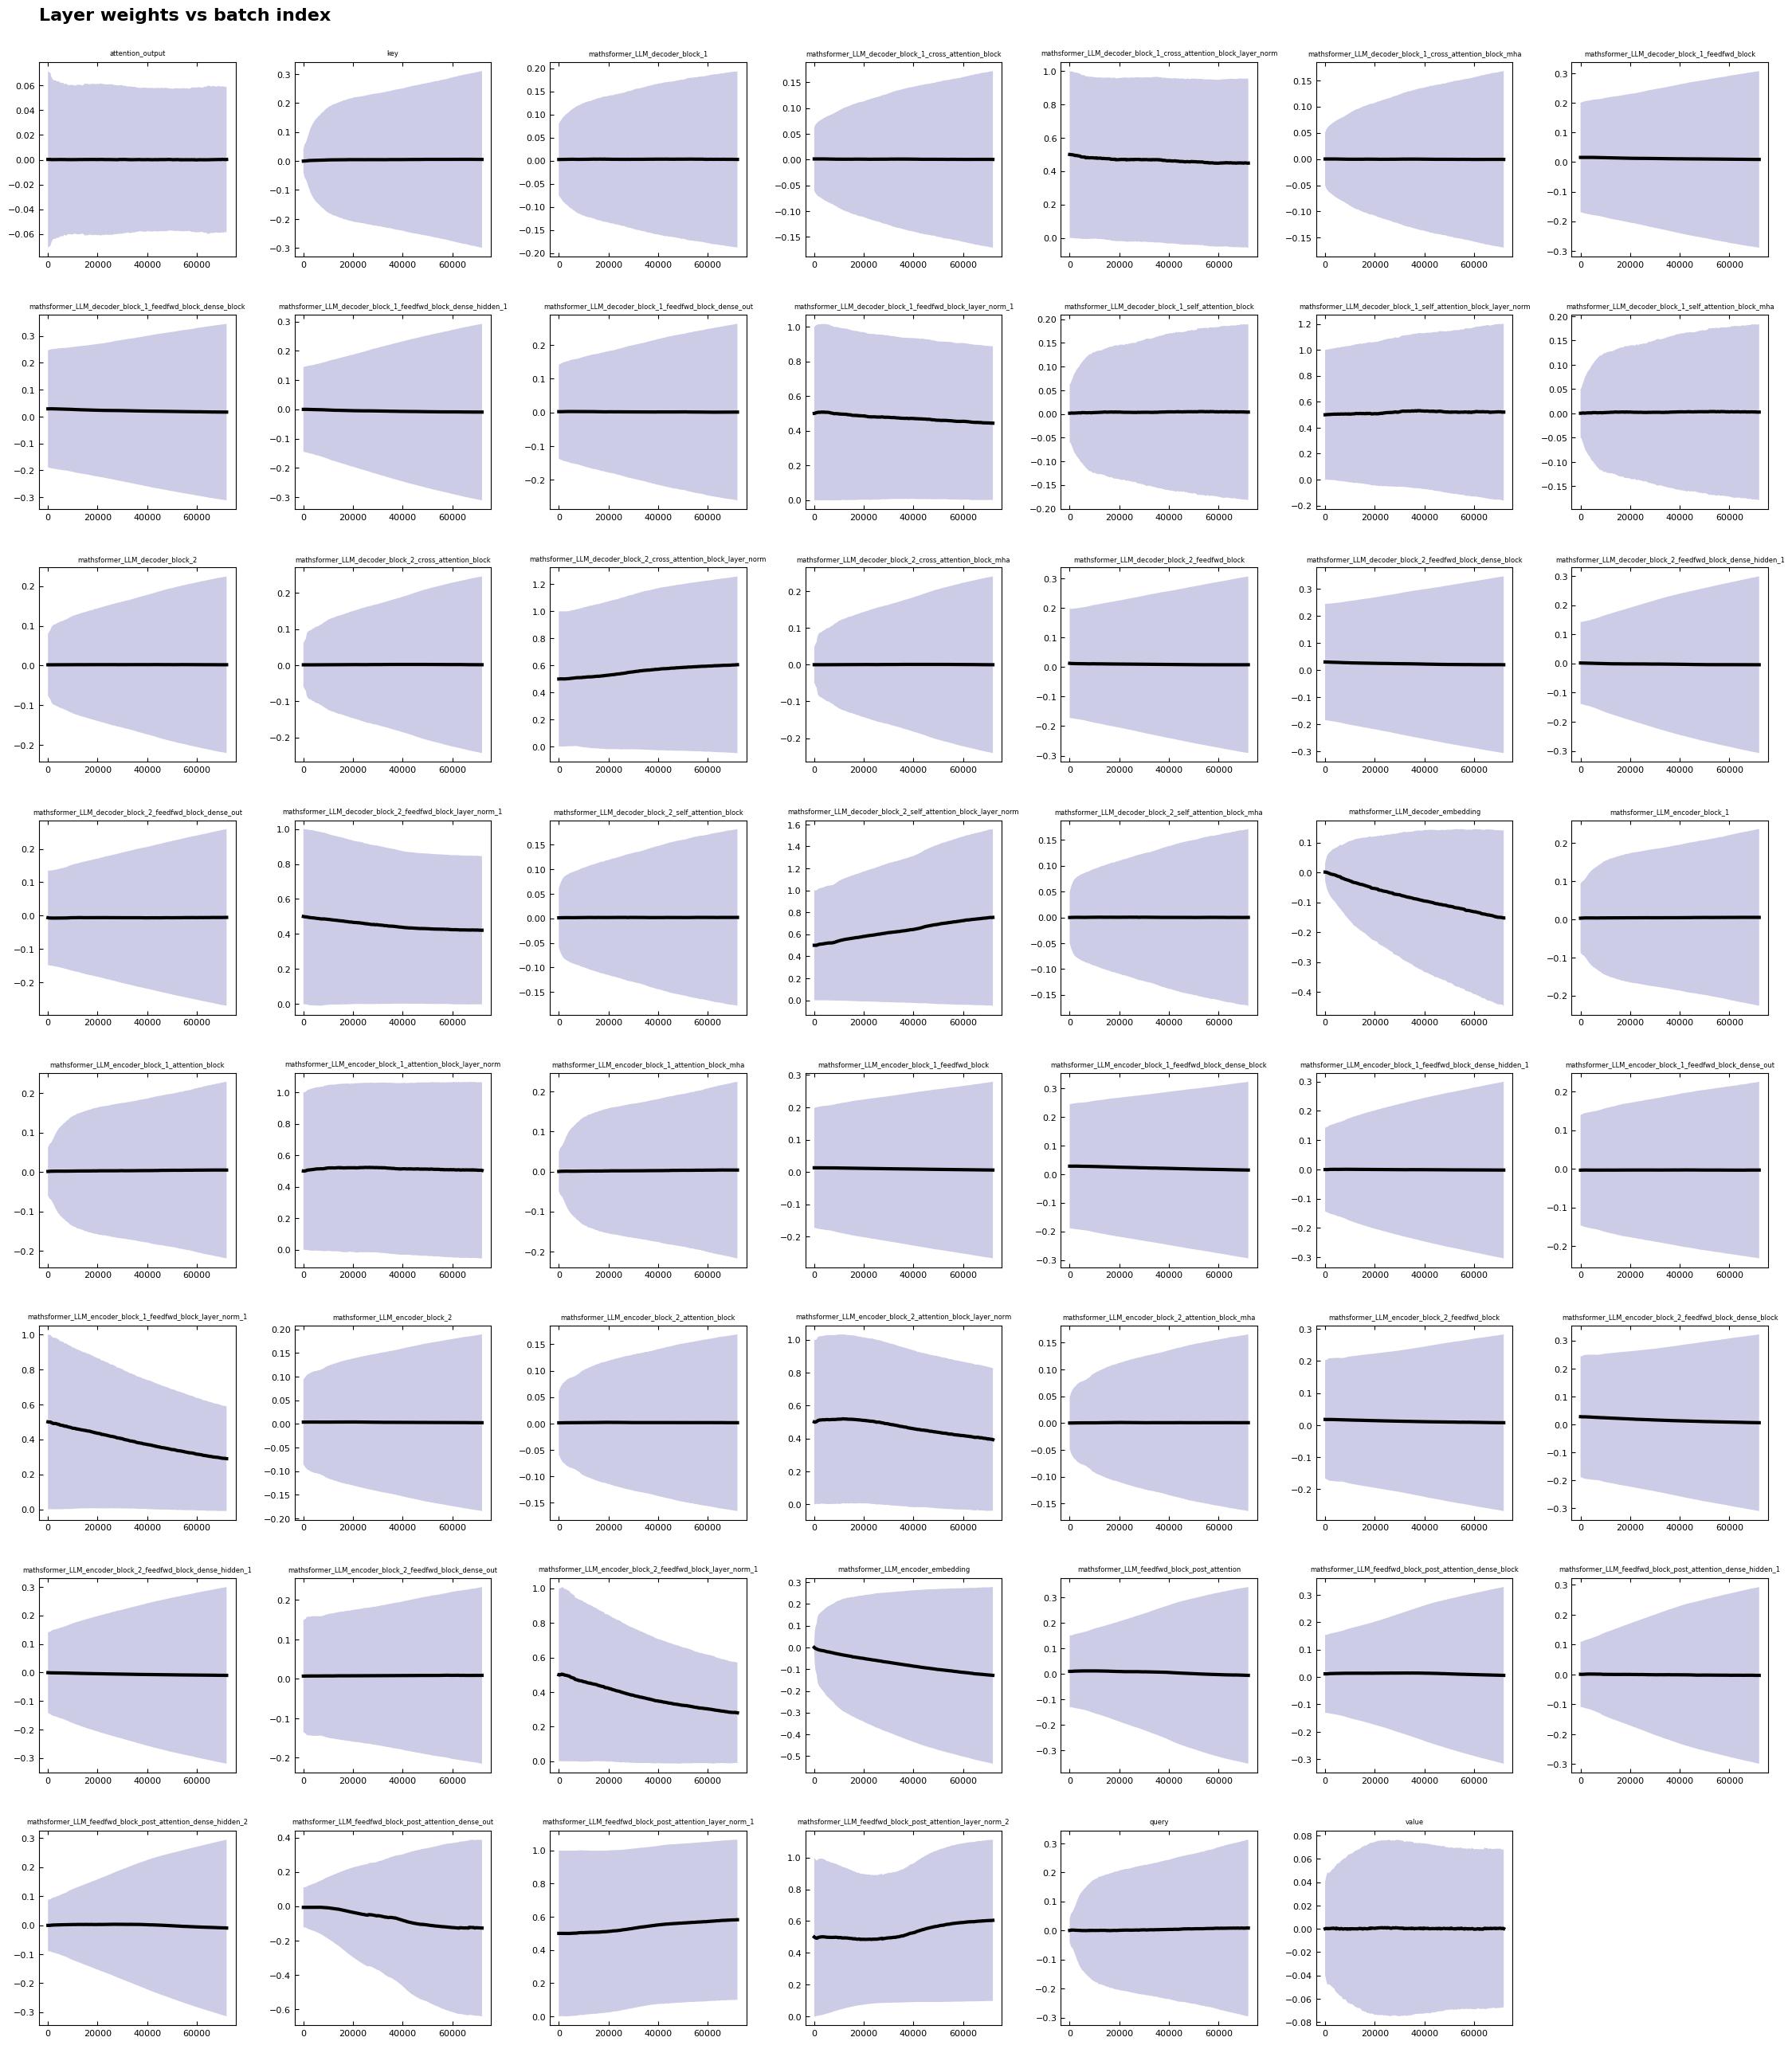

In [25]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if len(layer_weights_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    layer_weights_record.plot(num_col=7)
    